In [83]:
import pandas as pd
import vertica_python
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import os
import scipy
from scipy.stats import ttest_ind
import scipy.stats as stats

In [84]:
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')
conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}

In [85]:
sns.set_context("poster")
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
xkcd = sns.xkcd_palette(colors)

In [129]:
enroll_count_yearly = """

SELECT
	a.cnt_courses_enrolled,
	a.enrollment_year,
	COUNT(1) AS cnt_users,
	CAST(COUNT(1) * 100.0/b.cnt_enrolled_users AS FLOAT) AS pct_of_users,
	(COUNT(1) * a.cnt_courses_enrolled) as cnt_total_courses_enrolled,
	CAST((COUNT(1) * a.cnt_courses_enrolled) * 100.0/b.cnt_enrolls AS FLOAT) AS pct_of_enrolls
FROM
(
	SELECT
		user_id,
		CASE 
		when first_enrollment_time between '2014-01-01' and '2014-12-31' then '2014'
		when first_enrollment_time between '2015-01-01' and '2015-12-31' then '2015'
		when first_enrollment_time between '2016-01-01' and '2016-12-31' then '2016'
		END as enrollment_year,
		count(1) AS cnt_courses_enrolled
	FROM 
		production.d_user_course
	WHERE 
		first_enrollment_time between '2014-01-01' and '2016-12-31'
	GROUP BY 
		1,2
) a
JOIN
	(
	SELECT
		CASE 
		when first_enrollment_time between '2014-01-01' and '2014-12-31' then '2014'
		when first_enrollment_time between '2015-01-01' and '2015-12-31' then '2015'
		when first_enrollment_time between '2016-01-01' and '2016-12-31' then '2016'
		END as enrollment_year,
		count(distinct user_id) AS cnt_enrolled_users,
		count(1) as cnt_enrolls
	FROM 
		production.d_user_course
	WHERE 
		first_enrollment_time between '2014-01-01' and '2016-12-31'
	GROUP BY 
		1
	) b
ON
	a.enrollment_year = b.enrollment_year
WHERE 
	a.enrollment_year IS NOT NULL
GROUP BY
	a.cnt_courses_enrolled,
	a.enrollment_year,
	b.cnt_enrolls,
	b.cnt_enrolled_users
"""

In [130]:
connection = vertica_python.connect(**conn_info)


cur = connection.cursor('dict')
cur.execute(enroll_count_yearly)
extract = cur.fetchall()
enroll_count_df = pd.DataFrame(extract)

connection.close()

In [131]:
enroll_count_df['course_enroll_grouping'] = np.where(enroll_count_df['cnt_courses_enrolled'] >= 10, '>10', '<10')

In [132]:
enroll_count_ordered = enroll_count_df.sort_values('cnt_courses_enrolled', ascending=True)#.set_index('cnt_courses_enrolled')#.pivot('enrollment_year')

In [134]:
enroll_count_ordered.head()

,cnt_courses_enrolled,cnt_total_courses_enrolled,cnt_users,enrollment_year,pct_of_enrolls,pct_of_users,course_enroll_grouping
504,1,2240236,2240236,2015,19.830204,57.942453,<10
829,1,1022086,1022086,2014,16.725298,52.882090,<10
340,1,2714124,2714124,2016,19.247074,56.562880,<10
867,2,1598208,799104,2016,11.333612,16.653485,<10
923,2,1221558,610779,2015,10.813032,15.797458,<10


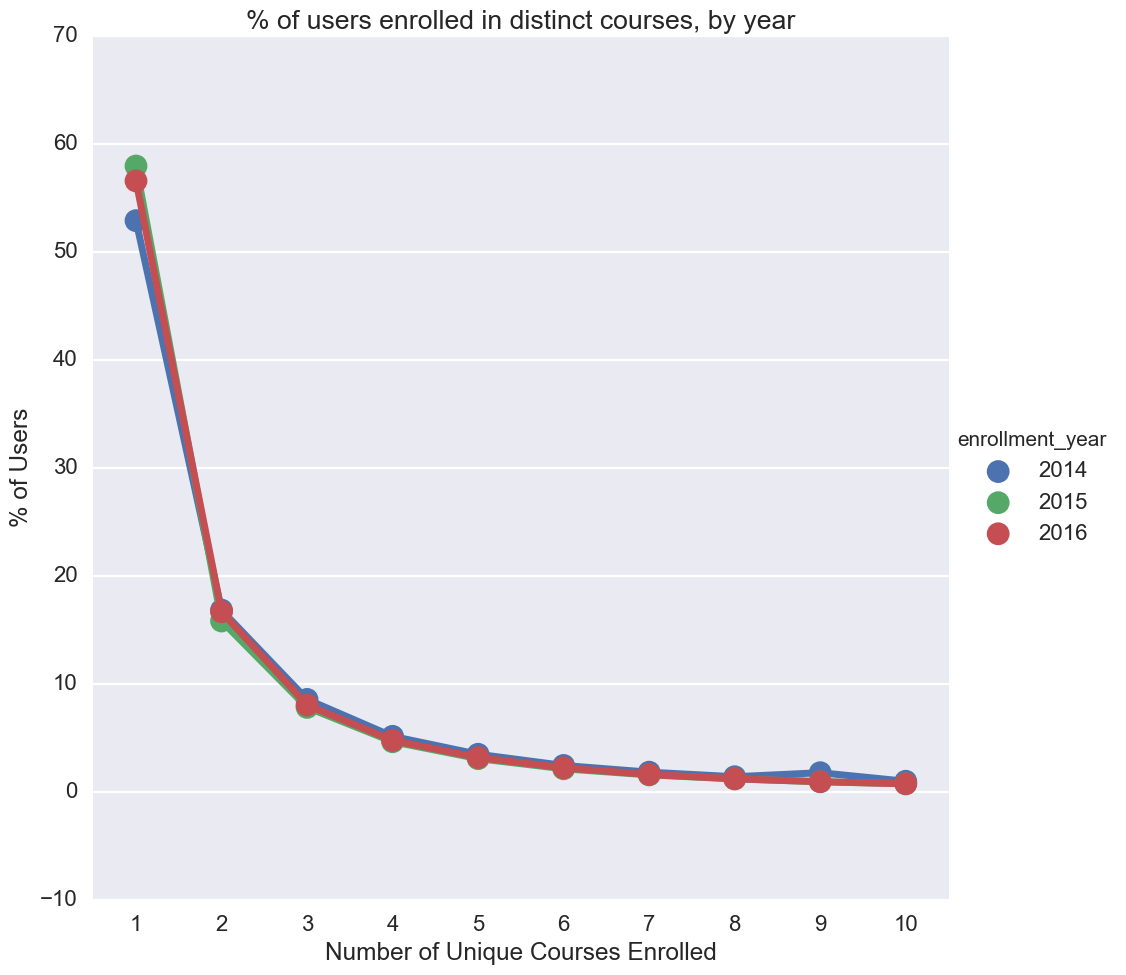

In [135]:
ax = sns.factorplot(data = enroll_count_ordered.head(30), x = 'cnt_courses_enrolled', 
               y='pct_of_users', hue='enrollment_year', kind='point', size = 10)
ax.set(title = '% of users enrolled in distinct courses, by year',
      xlabel='Number of Unique Courses Enrolled',
      ylabel='% of Users')

In [138]:
enroll_count_ordered_grouped = enroll_count_ordered.groupby(['enrollment_year','course_enroll_grouping']).sum().reset_index()

In [145]:
enroll_count_ordered_grouped

,enrollment_year,course_enroll_grouping,cnt_courses_enrolled,cnt_total_courses_enrolled,cnt_users,pct_of_enrolls,pct_of_users
0,2014,<10,45,3933461,1818912,64.366706,94.109369
1,2014,>10,38607,2177557,113852,35.633294,5.890631
2,2015,<10,45,7252882,3670017,64.201330,94.922939
3,2015,>10,75891,4044208,196295,35.798670,5.077061
4,2016,<10,45,9138782,4557388,64.807213,94.976866
5,2016,>10,115134,4962707,241031,35.192787,5.023134


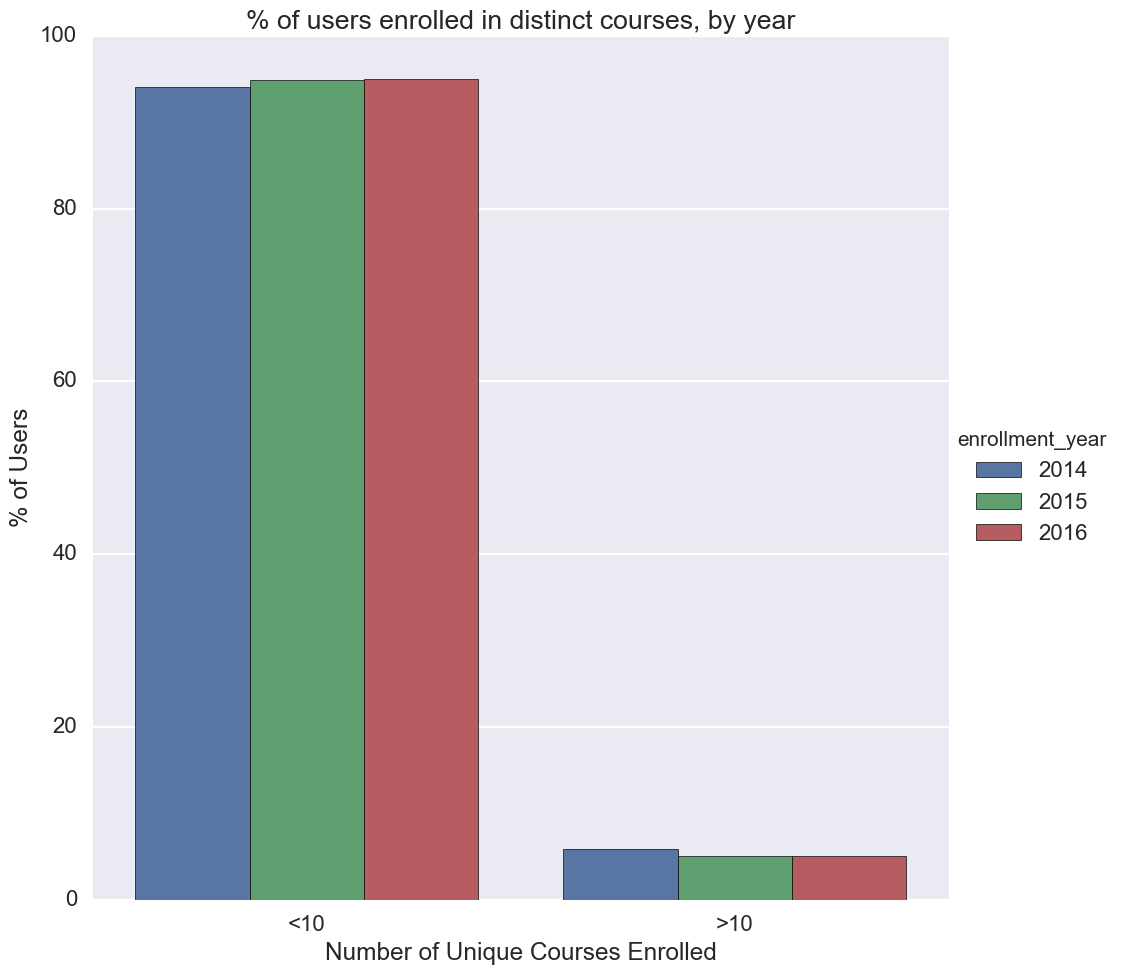

In [142]:
ax = sns.factorplot(data = enroll_count_ordered_grouped, x = 'course_enroll_grouping', 
               y='pct_of_users', hue='enrollment_year', kind='bar', size = 10)
ax.set(title = '% of users enrolled in distinct courses, by year',
      xlabel='Number of Unique Courses Enrolled',
      ylabel='% of Users')

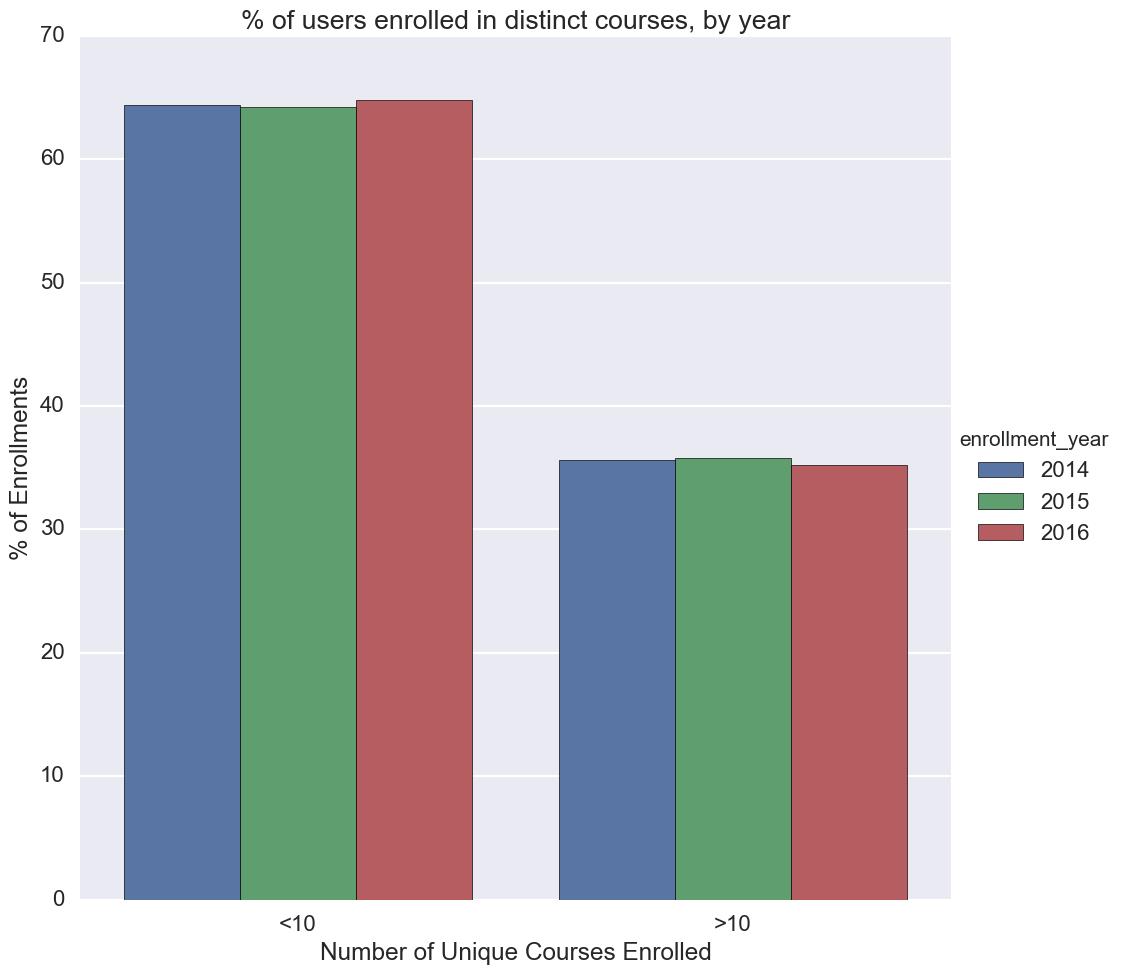

In [144]:
ax = sns.factorplot(data = enroll_count_ordered_grouped, x = 'course_enroll_grouping', 
               y='pct_of_enrolls', hue='enrollment_year', kind='bar', size = 10)
ax.set(title = '% of users enrolled in distinct courses, by year',
      xlabel='Number of Unique Courses Enrolled',
      ylabel='% of Enrollments')

In [146]:
enroll_count_df.to_csv(path='../../script_output/bisupport_48.csv')

',cnt_courses_enrolled,cnt_total_courses_enrolled,cnt_users,enrollment_year,pct_of_enrolls,pct_of_users,course_enroll_grouping\n0,882,882,1,2015,0.00780732029222,2.58644413591e-05,>10\n1,1059,1059,1,2016,0.00750984523691,2.08401975734e-05,>10\n2,38,17404,458,2014,0.284797066544,0.0236966334224,>10\n3,897,897,1,2016,0.00636103038481,2.08401975734e-05,>10\n4,230,690,3,2015,0.00610776757554,7.75933240773e-05,>10\n5,294,294,1,2015,0.00260244009741,2.58644413591e-05,>10\n6,200,400,2,2014,0.0065455542759,0.000103478748569,>10\n7,311,622,2,2015,0.00550584265506,5.17288827182e-05,>10\n8,1061,1061,1,2016,0.00752402813632,2.08401975734e-05,>10\n9,407,407,1,2016,0.00288622002967,2.08401975734e-05,>10\n10,58,16182,279,2016,0.114753839116,0.00581441512298,>10\n11,198,198,1,2014,0.00324004936657,5.17393742847e-05,>10\n12,66,12738,193,2015,0.112754700547,0.00499183718231,>10\n13,119,952,8,2014,0.0155784191766,0.000413914994278,>10\n14,228,684,3,2015,0.00605465655315,7.75933240773e-05,>10\n15,222,888,